In [1]:
#Mount your Google Drive in Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Navigate to the directory where your rar file is located 
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [3]:
ls

 boneage-dataset/      bone_age_weights.best.hdf5   cropped/
 boneage-dataset.csv   classification.ipynb         trained_img_predictions.png
 boneage-dataset.rar  'Colab Notebooks'/


In [4]:
import cv2
import numpy as np
import pandas as pd
from google.colab import files

In [5]:
df = pd.read_csv('boneage-dataset.csv')

In [6]:
df.head()

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False


In [7]:
df.shape

(2358, 3)

In [8]:
# Count the number of null values in each column
df.isnull().sum()

id         0
boneage    0
male       0
dtype: int64

In [9]:
ids = df['id'].values
ages = df['boneage'].values

In [10]:
from google.colab.patches import cv2_imshow
import os
import csv

# Set the directory path
directory = "boneage-dataset/boneage-dataset"

directory_new = "cropped"
if not os.path.exists(directory_new):
    os.makedirs(directory_new)

images = []
paths = []
images_paths = []


# Loop over each file in the directory
for filename in os.listdir(directory):
    # Check if the file is an image
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Open the image file
        image_file = os.path.join(directory, filename)
        image = cv2.imread(image_file)

        # Resize the image
        resized_img = cv2.resize(image, (200, 300))

        # Convert the image to grayscale
        gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)

        # Apply simple thresholding with a fixed threshold value of 200
        thresh = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 1)

        # Apply morphological opening to remove small objects
        kernel = np.ones((1, 1), np.uint8)
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

        # Find contours in the binary image
        contours, hierarchy = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Find the contour with the largest area
        max_area = 0
        max_contour = None
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > max_area:
                max_area = area
                max_contour = contour

        # Crop the image to the bounding rectangle of the largest contour
        x, y, w, h = cv2.boundingRect(max_contour)
        cropped_img = resized_img[y:y+h, x:x+w]
        image = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        image = cv2.equalizeHist(image)  # apply histogram equalization
        images.append(image)
        
         # Create the new path for the cropped image
        images_path = os.path.join(directory_new, filename)
        cv2.imwrite(images_path, image)
        images_paths.append(images_path)
   

        # Append the image path to the paths list
        paths.append(image_file)


In [11]:
len(images)

150

In [12]:
id = []
for path in images_paths:
    image_id = os.path.splitext(os.path.basename(path))[0]
    #print(image_id)
    id.append(image_id)

In [13]:
# Combine the lists into a list of tuples
tuples = list(zip(id, images_paths))

# Create data frames from the list of tuples
df_new = pd.DataFrame(tuples, columns=['id', 'images_paths'])

In [14]:
#cast the object to int
df_new['id'] = df_new['id'].astype('int64')

In [15]:
# merge the dataframes on 'id' column
merged_df = pd.merge(df, df_new, on='id', how='inner')

print(merged_df)

       id  boneage   male      images_paths
0    1790      114   True  cropped/1790.png
1    1793      180  False  cropped/1793.png
2    1818      204   True  cropped/1818.png
3    1846      168   True  cropped/1846.png
4    1902      228   True  cropped/1902.png
..    ...      ...    ...               ...
145  3937      165   True  cropped/3937.png
146  3963      156  False  cropped/3963.png
147  3976      106  False  cropped/3976.png
148  3995      144   True  cropped/3995.png
149  3996      144  False  cropped/3996.png

[150 rows x 4 columns]


In [16]:
# Count the number of null values in each column
merged_df.isnull().sum()

id              0
boneage         0
male            0
images_paths    0
dtype: int64

In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
%matplotlib inline 

In [18]:
merged_df['images_paths'] = merged_df['images_paths'].astype(str)


# Define a function to check if a file exists at a given path
def file_exists(file_path):
    return os.path.exists(file_path)

# Create a new column in the DataFrame indicating whether each file exists or not
merged_df['file_exists'] = merged_df['images_paths'].apply(file_exists)

# Count the number of files that exist
num_files_exist = merged_df['file_exists'].sum()

# Print the result
print(f"{num_files_exist} images found of {merged_df.shape[0]} total")

150 images found of 150 total


In [19]:
merged_df['gender'] = merged_df['male'].map(lambda x: 'male' if x else 'female')
merged_df.dropna(inplace = True)

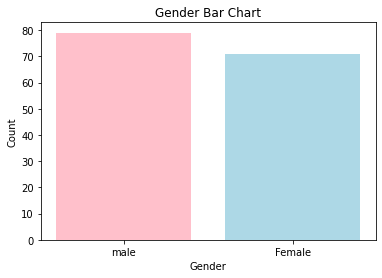

In [20]:
# Get the counts of each gender category
gender_counts = merged_df['gender'].value_counts()

# Create a list of colors for each category
colors = ['pink', 'lightblue']

# Create a bar chart
plt.bar(gender_counts.index, gender_counts.values,color=colors)
plt.xticks(gender_counts.index, ['male', 'Female'])

# Add labels and title
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Bar Chart')


# Show the plot
plt.show()

In [21]:
# mean
boneage_mean = merged_df['boneage'].mean()
#satndard deviatio
boneage_div = 2*merged_df['boneage'].std()
#boneage_zscore
merged_df['boneage_zscore'] = merged_df['boneage'].map(lambda x: (x-boneage_mean)/boneage_div)

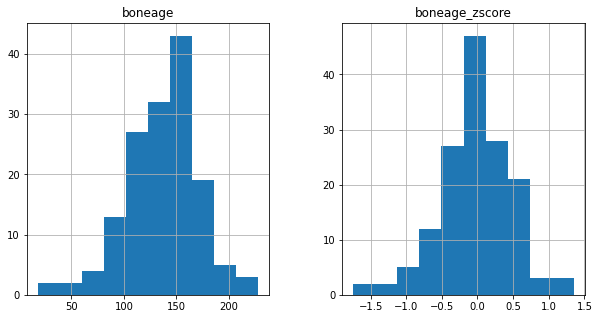

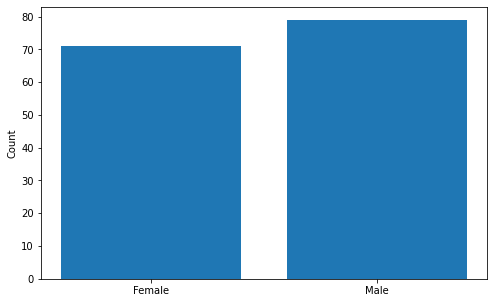

In [22]:
#Age is shown in months
merged_df[['boneage', 'boneage_zscore']].hist(figsize = (10, 5))
# plot male count histogram
male_counts = merged_df['male'].value_counts()
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(male_counts.index, male_counts.values)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Female', 'Male'])
ax.set_ylabel('Count')
plt.show()

In [23]:
# Create 8 age groups based on bone age values using the qcut() function
age_groups = 8
merged_df['age_class'] = pd.qcut(merged_df['boneage'], age_groups)

# Group the data by age class and gender, and select a random sample from each group
age_overview_df = merged_df.groupby(['age_class', 'gender']).apply(lambda x: x.sample(1)).reset_index(drop=True)

In [24]:
# Create a figure with subplots for each age group and gender combination
fig, m_axs = plt.subplots(age_groups, 2, figsize=(12, 6*age_groups))

# Iterate over each subplot and display a sample image
for c_ax, (_, c_row) in zip(m_axs.flatten(), age_overview_df.sort_values(['age_class', 'gender']).iterrows()):
    # Load the image using the path in the DataFrame
    c_ax.imshow(imread(c_row['images_paths']), cmap='viridis')
    # Hide the axis and set the title to the bone age and gender
    c_ax.axis('off')
    c_ax.set_title('{boneage} months, {gender}'.format(**c_row))

Output hidden; open in https://colab.research.google.com to view.

New Data Size: 1400 Old Size: 150


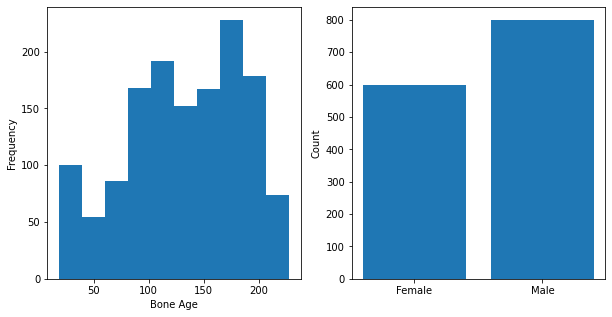

In [25]:
# Create a new column called 'boneage_category' by dividing the 'boneage' column into 8 equally sized bins
merged_df['boneage_category'] = pd.cut(merged_df['boneage'], 8)

# Convert the 'boneage_category' column to an integer that represents the bin number
merged_df['bin_number'] = pd.factorize(merged_df['boneage_category'])[0]

# Group the original dataframe by 'bin_number' and 'male', then randomly select 100 samples (with replacement) from each group
new_merged_df = merged_df.groupby(['bin_number', 'male']).apply(lambda x: x.sample(100, replace=True)).reset_index(drop=True)

# Print out the size of the new dataframe and the old dataframe
print('New Data Size:', new_merged_df.shape[0], 'Old Size:', merged_df.shape[0])

# Plot histograms of the 'boneage' and 'male' columns in the new dataframe
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# plot bone age histogram
ax1.hist(new_merged_df['boneage'], bins=10)
ax1.set_xlabel('Bone Age')
ax1.set_ylabel('Frequency')

# plot male count histogram
male_counts = new_merged_df['male'].value_counts()
ax2.bar(male_counts.index, male_counts.values)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Female', 'Male'])
ax2.set_ylabel('Count')
plt.show()

In [26]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [42]:
# split the data in to test data as 25% and  train data
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(merged_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = merged_df['boneage_category'])
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 112 validation 38


In [43]:
#genrate new images
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (512, 512)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 10, 
                              shear_range = 0.05,
                              fill_mode = 'nearest',
                              zoom_range=0.15)

In [44]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.filepaths.extend(df_gen.filenames)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [45]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'images_paths',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 64)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'images_paths',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 64) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               valid_df, 
                             path_col = 'images_paths',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 500)) # one big batch

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 112 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 38 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 38 images


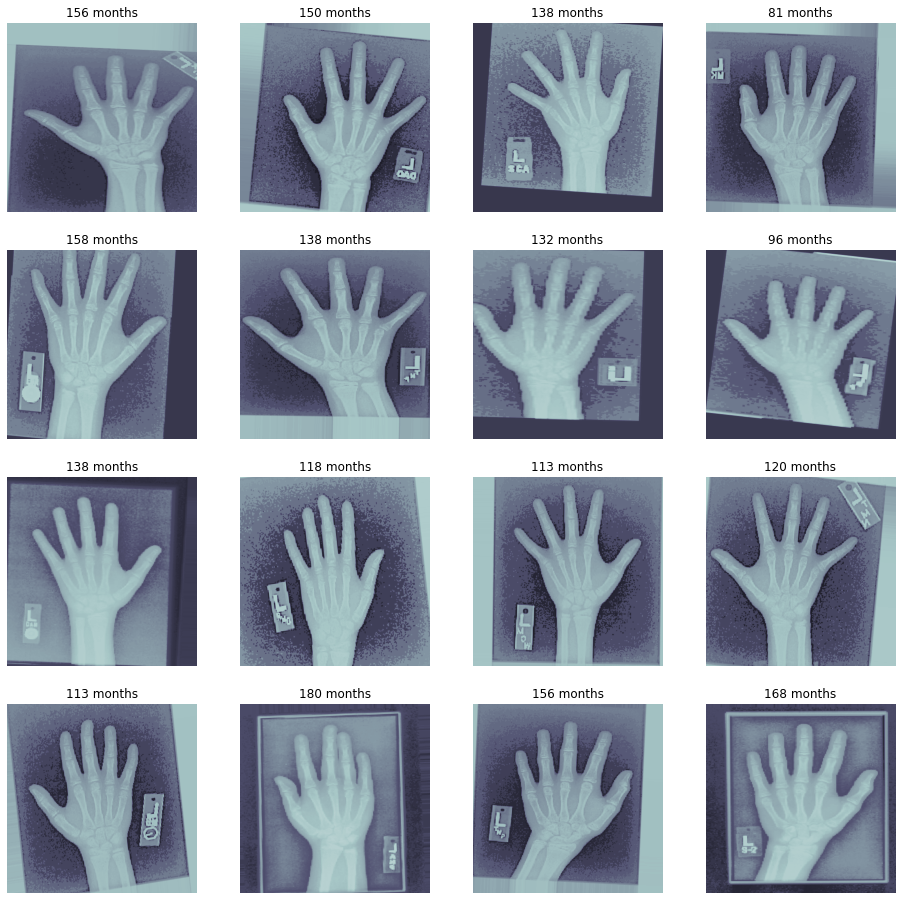

In [47]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -3, vmax = 3)
    c_ax.set_title('%2.0f months' % (c_y*boneage_div+boneage_mean))
    c_ax.axis('off')

In [48]:
#MobileNet model
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization
from keras.models import Sequential
base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, 
                                 weights = None)
bone_age_model = Sequential()
bone_age_model.add(BatchNormalization(input_shape = t_x.shape[1:]))
bone_age_model.add(base_mobilenet_model)
bone_age_model.add(BatchNormalization())
bone_age_model.add(GlobalAveragePooling2D())
bone_age_model.add(Dropout(0.5))
bone_age_model.add(Dense(1, activation = 'linear' )) # linear is what 16bit did
from keras.metrics import mean_absolute_error
def mae_months(in_gt, in_pred):
    return mean_absolute_error(boneage_div*in_gt, boneage_div*in_pred)

bone_age_model.compile(optimizer = 'adam', loss = 'mse',
                           metrics = [mae_months])

bone_age_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 512, 512, 1)      4         
 ormalization)                                                   
                                                                 
 mobilenet_1.00_512 (Functio  (None, 16, 16, 1024)     3228288   
 nal)                                                            
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 1024)     4096      
 hNormalization)                                                 
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0

In [50]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
# file name is set to 'bone_age_weights.best.hdf5
weight_path="{}_weights.best.hdf5".format('bone_age')

# creates a ModelCheckpoint object that will monitor the validation loss during training and save the weights of the best performing model to a file
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

# callbacks during training a deep learning model 
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [51]:
#fit the model in to the mobile net
train_gen.batch_size = 16
bone_age_model.fit_generator(train_gen, 
                                  validation_data = (test_X, test_Y), 
                                  epochs = 4, 
                                  callbacks = callbacks_list)

<ipython-input-51-ed021f3924ba>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  bone_age_model.fit_generator(train_gen,


Epoch 1/4
7/7 [==============================] - ETA: 0s - loss: 1.8594 - mae_months: 56.8282 
Epoch 1: val_loss improved from inf to 0.22371, saving model to bone_age_weights.best.hdf5
7/7 [==============================] - 106s 14s/step - loss: 1.8594 - mae_months: 56.8282 - val_loss: 0.2237 - val_mae_months: 24.1424 - lr: 0.0010
Epoch 2/4
7/7 [==============================] - ETA: 0s - loss: 0.3579 - mae_months: 31.1668 
Epoch 2: val_loss did not improve from 0.22371
7/7 [==============================] - 98s 14s/step - loss: 0.3579 - mae_months: 31.1668 - val_loss: 0.2807 - val_mae_months: 28.5575 - lr: 0.0010
Epoch 3/4
7/7 [==============================] - ETA: 0s - loss: 0.3113 - mae_months: 29.4276 
Epoch 3: val_loss did not improve from 0.22371
7/7 [==============================] - 97s 14s/step - loss: 0.3113 - mae_months: 29.4276 - val_loss: 0.4640 - val_mae_months: 40.2910 - lr: 0.0010
Epoch 4/4
7/7 [==============================] - ETA: 0s - loss: 0.2583 - mae_months: 26

In [52]:
# fit the weight_path in to the model
bone_age_model.load_weights(weight_path)

In [53]:
#prediction 
pred_Y = boneage_div*bone_age_model.predict(test_X, batch_size = 16, verbose = True)+boneage_mean
test_Y_months = boneage_div*test_Y+boneage_mean

3/3 [==============================] - 11s 3s/step


Text(0, 0.5, 'Predicted Age (Months)')

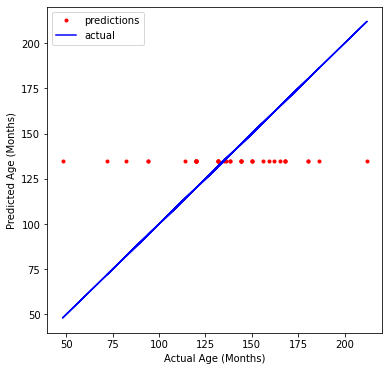

In [54]:
# actual vs prediced scatter plot
fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(test_Y_months, pred_Y, 'r.', label = 'predictions')
ax1.plot(test_Y_months, test_Y_months, 'b-', label = 'actual')
ax1.legend()
ax1.set_xlabel('Actual Age (Months)')
ax1.set_ylabel('Predicted Age (Months)')

In [55]:
# Assuming you have a test set of images and corresponding labels, test_x and test_y
test_loss, test_accuracy = bone_age_model.evaluate(test_X, test_Y)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

2/2 [==============================] - 8s 1s/step - loss: 0.2237 - mae_months: 24.1424
Test loss: 0.22371196746826172
Test accuracy: 24.142377853393555
